# Rubiks Models

## Load and inspect libraries/data

In [129]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
from keras.models import Sequential 
from keras.layers import Dense, Flatten, InputLayer
from keras.metrics import BinaryAccuracy
import colorsys
from skimage.measure import label
import json
import uuid

In [32]:
def load_images(image_dir, include_file_order=False):
    # Lists to store loaded images.
    input_images = []

    # Ensure the directory exists and contains images.
    if not os.path.isdir(image_dir):
        raise ValueError("One of the directories does not exist.")

    file_order = []
    # Iterate through the filenames in the directory.
    for filename in os.listdir(image_dir):
        file_order.append(filename)

        # Construct the full path to the image file.
        image_path = os.path.join(image_dir, filename)

        # Load the image and convert it to a numpy array.
        with Image.open(image_path) as img:
            input_images.append(np.array(img))

    # Convert lists to numpy arrays.
    input_images = np.array(input_images)

    if include_file_order:
        return input_images, file_order
    else:
        return input_images

In [33]:
def load_in_and_out_images(input_dir, labels_dir, include_file_order=False):
    # Lists to store loaded images
    input_images = []
    label_images = []

    # Ensure the directory exists and contains images
    if not os.path.isdir(input_dir) or not os.path.isdir(labels_dir):
        raise ValueError("One of the directories does not exist.")

    file_order = []
    # Iterate through the filenames in the input directory
    for filename in os.listdir(input_dir):
      file_order.append(filename)
      # Construct the full path to the image file
      input_path = os.path.join(input_dir, filename)
      label_path = os.path.join(labels_dir, filename)

      # Check if the corresponding label image exists
      if os.path.exists(label_path):
          # Open, load the image and convert it to a numpy array
          with Image.open(input_path) as img:
              input_images.append(np.array(img))
          with Image.open(label_path) as img:
              label_images.append(np.array(img))
      else:
          print(f"Label for {filename} not found.")

    # Convert lists to numpy arrays
    input_images = np.array(input_images)
    label_images = np.array(label_images)

    if include_file_order:
      return input_images, label_images, file_order
    else:
      return input_images, label_images

In [34]:
color_classes = {
  (0, 255, 0): 0,
  (255, 255, 0): 1,
  (0, 0, 255): 2,
  (255, 255, 255): 3,
  (255, 0, 0): 4,
  (255, 210, 0): 5
}

color_names = [
    "green",
    "yellow",
    "blue",
    "white",
    "red",
    "orange"
]


### Plotting Functions

In [35]:
def plot_images(images, title=None, cm=None):
    plt.figure()
    plt.tight_layout()
    n = len(images)
    for i, image in enumerate(images):
      plt.subplot(int("1" + str(n) + str(i+1)))
      if cm:
        plt.imshow(image, cmap=cm)
      else:
        plt.imshow(image)

    if title:
      plt.suptitle(title)

In [98]:
def plot_images_grid(images, nrows, ncols, sub_titles=None, title=None):
    plt.figure()
    n = len(images)
    fig, axs = plt.subplots(nrows, ncols)

    for i, ax in enumerate(axs.flat):
      ax.axis("off")
      if isinstance(sub_titles, np.ndarray) or sub_titles:
        ax.set_title(sub_titles[i])

    for i, image in enumerate(images):
      plt.subplot(nrows, ncols, i+1)

      plt.tight_layout()
      plt.imshow(image)

    if title:
      plt.title(title)

In [100]:
# Visualize each subarea of the segmentation mask with a unique color.
def generate_unique_colors(n):
    # Generate colors by varying the Hue, keeping Saturation and Lightness constant.
    colors = []
    for i in range(n):
        hue = i / n
        saturation = 0.7
        lightness = 0.6
        rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
        colors.append(rgb)

    return colors

def plot_labeled_mask(mask):
  unique_colors = generate_unique_colors(np.max(mask))
  unique_colors = [[0.5, 0.5, 0.5]] + unique_colors # add background color.
  unique_colors = np.array(unique_colors)

  img = unique_colors[mask]
  plot_images([img])

In [101]:
def draw_point(image, y, x):
  k=1
  for row in range(y-k, y+k+1):
    for col in range(x-k, x+k+1):

      image[row][col] = np.array([1, 0, 1])

def draw_centers(image, centers):
  img_cpy = image+0.5

  for i, center in enumerate(centers):
    draw_point(img_cpy, center[0], center[1])

  plot_images([img_cpy])

### Preprocessing Functions

In [37]:
def normalize(image):
    return (image / 255.0) - 0.5

In [38]:
def reduce(image):
    return image[:, :, :, :1]

In [39]:
def substitute_values(image):
  image[image == 255] = 2

In [40]:
# Base class for models.
class Model:
    def __init__(self, input_dir, output_dir):
        input_data, output_data = load_in_and_out_images(input_dir, output_dir)
        input_data, output_data = self.preprocess(input_data, output_data)
        self.train_dataset, self.validation_dataset, self.test_dataset = (
            self.prepare_dataset(input_data, output_data)
        )

    def preprocess(self, input_data, output_data):
        # preprocessing will be different for each model.
        pass

    def prepare_dataset(self, input_data, output_data):
        DataSplitRatios = (0.7, 0.2, 0.1)
        n = len(input_data)
        split1ix = int(n * DataSplitRatios[0])
        split2ix = int(n * (DataSplitRatios[0] + DataSplitRatios[1]))

        train_dataset = {
            "input": input_data[:split1ix],
            "output": output_data[:split1ix],
        }
        validation_dataset = {
            "input": input_data[split1ix:split2ix],
            "output": output_data[split1ix:split2ix],
        }
        test_dataset = {
            "input": input_data[split2ix:],
            "output": output_data[split2ix:],
        }

        assert (
            len(train_dataset["input"]) + len(validation_dataset["input"]) + len(test_dataset["input"])
            == n
        )

        return train_dataset, validation_dataset, test_dataset

    def build(self):
        # Model will be different for each model.
        pass

    def compile(self):
        pass

    def summary(self):
        self.model.summary()

    def train(self):
        pass

    def predict(self, input_data):
        return self.model.predict(input_data)

## Image Segmentation with U-Net

### Define U-Net Model
The implementation of U-Net is copied from [this notebook](https://colab.research.google.com/github/margaretmz/image-segmentation/blob/main/unet_pet_segmentation.ipynb#scrollTo=RoNAcRnMzlrC) and the corresponding [blog post](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/).

In [43]:
# U-NET model for image segmentation.
class SegmentationModel(Model):
    def __init__(self, input_dir, output_dir):
        super().__init__(input_dir, output_dir)

    def preprocess(self, input_data, output_data):
        input_data = normalize(input_data)

        output_data = reduce(
            output_data
        )  # Only one color channel is necessary for the mask.
        substitute_values(output_data)

        return input_data, output_data

    def build(self):
        def double_conv_block(x, n_filters):
            # Conv2D then ReLU activation
            x = layers.Conv2D(
                n_filters,
                3,
                padding="same",
                activation="relu",
                kernel_initializer="he_normal",
            )(x)
            # Conv2D then ReLU activation
            x = layers.Conv2D(
                n_filters,
                3,
                padding="same",
                activation="relu",
                kernel_initializer="he_normal",
            )(x)

            return x

        def downsample_block(x, n_filters):
            f = double_conv_block(x, n_filters)
            p = layers.MaxPool2D(2)(f)
            p = layers.Dropout(0.3)(p)

            return f, p

        def upsample_block(x, conv_features, n_filters):
            # upsample
            x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
            # concatenate
            x = layers.concatenate([x, conv_features])
            # dropout
            x = layers.Dropout(0.3)(x)
            # Conv2D twice with ReLU activation
            x = double_conv_block(x, n_filters)

            return x

        def build_unet_model():
            # inputs
            inputs = layers.Input(shape=(128, 128, 3))

            # encoder: contracting path - downsample
            # 1 - downsample
            f1, p1 = downsample_block(inputs, 64)
            # 2 - downsample
            f2, p2 = downsample_block(p1, 128)
            # 3 - downsample
            f3, p3 = downsample_block(p2, 256)
            # 4 - downsample
            f4, p4 = downsample_block(p3, 512)

            # 5 - bottleneck
            bottleneck = double_conv_block(p4, 1024)

            # decoder: expanding path - upsample
            # 6 - upsample
            u6 = upsample_block(bottleneck, f4, 512)
            # 7 - upsample
            u7 = upsample_block(u6, f3, 256)
            # 8 - upsample
            u8 = upsample_block(u7, f2, 128)
            # 9 - upsample
            u9 = upsample_block(u8, f1, 64)

            # outputs
            outputs = layers.Conv2D(3, 1, padding="same", activation="softmax")(u9)

            # unet model with Keras Functional API
            unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

            return unet_model

        self.model = build_unet_model()

    def compile(self):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss="sparse_categorical_crossentropy",
            metrics="accuracy",
        )

    def train(self):
        model_history = self.model.fit(
            x=self.train_dataset["input"],
            y=self.train_dataset["output"],
            batch_size=32,
            epochs=20,
            # shuffle=True,
            validation_data=(
                self.validation_dataset["input"],
                self.validation_dataset["output"],
            ),
        )

        return model_history

In [44]:
input_dir = '/home/rubiks-volume/data-ready-for-training/segmentation-input'
labels_dir = '/home/rubiks-volume/data-ready-for-training/segmentation-output'
segmentationModel = SegmentationModel(input_dir, labels_dir)

<Figure size 640x480 with 0 Axes>

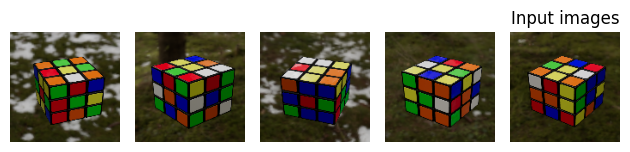

<Figure size 640x480 with 0 Axes>

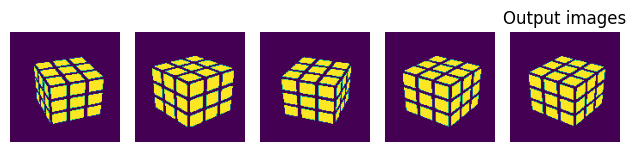

In [45]:
plot_images_grid(segmentationModel.train_dataset["input"][:5]+0.5, 1, 5, title="Input images")
plot_images_grid(segmentationModel.train_dataset["output"][:5], 1, 5, title="Output images")

### Build, compile and train U-Net

In [46]:
segmentationModel.build()
segmentationModel.compile()
segmentationModel.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_25 (Conv2D)          (None, 128, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_26 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_25[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_26[0][0]']           
 g2D)                                                                                         

In [47]:
segmentationModel.train()

Epoch 1/20
22/22 [==============================] - 8s 172ms/step - loss: 0.7958 - accuracy: 0.7807 - val_loss: 0.3078 - val_accuracy: 0.8638
Epoch 2/20
22/22 [==============================] - 3s 155ms/step - loss: 0.2019 - accuracy: 0.9110 - val_loss: 0.1187 - val_accuracy: 0.9448
Epoch 3/20
22/22 [==============================] - 3s 156ms/step - loss: 0.1039 - accuracy: 0.9516 - val_loss: 0.1821 - val_accuracy: 0.9280
Epoch 4/20
22/22 [==============================] - 3s 157ms/step - loss: 0.0915 - accuracy: 0.9600 - val_loss: 0.0688 - val_accuracy: 0.9725
Epoch 5/20
22/22 [==============================] - 3s 156ms/step - loss: 0.0651 - accuracy: 0.9732 - val_loss: 0.0528 - val_accuracy: 0.9782
Epoch 6/20
22/22 [==============================] - 3s 156ms/step - loss: 0.0483 - accuracy: 0.9816 - val_loss: 0.0470 - val_accuracy: 0.9816
Epoch 7/20
22/22 [==============================] - 3s 159ms/step - loss: 0.0371 - accuracy: 0.9853 - val_loss: 0.0358 - val_accuracy: 0.9859
Epoch 

### Evaluate U-Net
<mark>TODO:</mark> Plot loss/accuracy over ephochs etc.

4/4 [==============================] - 1s 100ms/step


<Figure size 640x480 with 0 Axes>

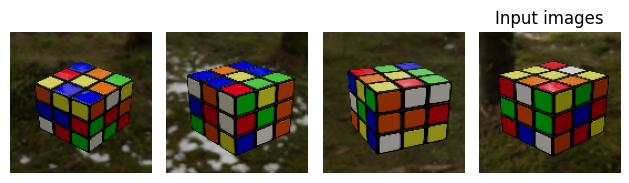

<Figure size 640x480 with 0 Axes>

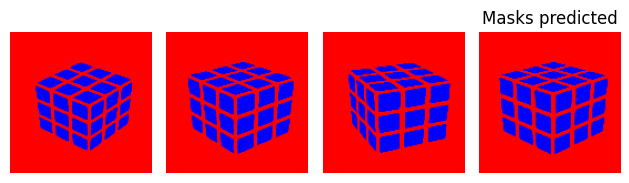

In [49]:
masks_predicted = segmentationModel.predict(segmentationModel.test_dataset["input"])

plot_images_grid(segmentationModel.test_dataset["input"][:4]+0.5, 1, 4, title="Input images")
plot_images_grid(masks_predicted[:4], 1, 4, title="Masks predicted")


In [141]:
# The model seems fine, save it to disk so that it can be used for preprocessing in the future.
segmentationModel.model.save('/home/rubiks-volume/models/segmentation_model')

## Split segmentation mask into subareas

In [50]:
# Convert the masks to binary format.
def format_masks(masks):
  masks = np.copy(masks[:,:,:,0])
  masks[masks < 0.5] = 0
  masks[masks >= 0.5] = 1
  masks = ~masks.astype(bool)
  return masks

# Split masks into subareas.
def label_masks(formated_masks):
    labeled_masks = [label(mask, connectivity=2) for mask in formated_masks]
    labeled_masks = np.array(labeled_masks)
    return labeled_masks

### Analysis of threshold value

mean: 135.07347538574578
std: 58.507142391728664
min: 1
max: 320


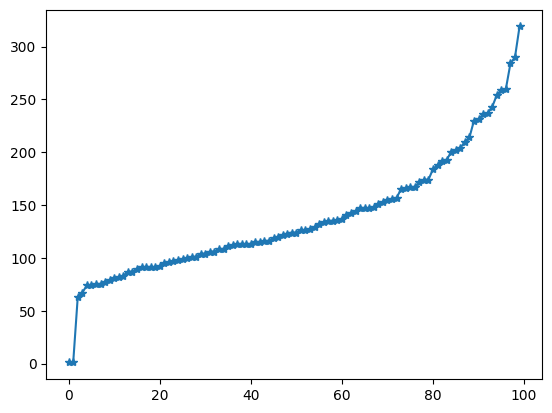

In [51]:
# Analyze the size of all areas to get an understanding of a reasonable
# threshold value for the apply_threshold function.
def get_area_sizes():
  all_areas_sizes = []
  for labeled_mask in label_masks(format_masks(masks_predicted)):
    _, unique_counts = np.unique(labeled_mask, return_counts=True)

    # Ignore the first class (background)
    all_areas_sizes += list(unique_counts[1:])

  return np.array(all_areas_sizes)

all_areas_sizes = get_area_sizes()

print(f"mean: {np.mean(all_areas_sizes)}")
print(f"std: {np.std(all_areas_sizes)}")
print(f"min: {np.min(all_areas_sizes)}")
print(f"max: {np.max(all_areas_sizes)}")
plt.plot(sorted(list(all_areas_sizes)[:100]), "-*")

In [52]:
# Apply a threshold function to filter out small areas (noise).
# Assign background class (0) to all pixels belonging to invalid classes.
# From the analysis further down 16 seems like a reasonable threshold for a valid side.
def apply_threshold(labeled_masks, threshold=16):
  for idx in range(labeled_masks.shape[0]):
    label_classes, counts = np.unique(labeled_masks[idx], return_counts=True)
    invalid_classes = label_classes[counts < threshold]
    for invalid_class in invalid_classes:
      labeled_masks[idx][labeled_masks[idx] == invalid_class] = 0

### Process and visualize masks subareas

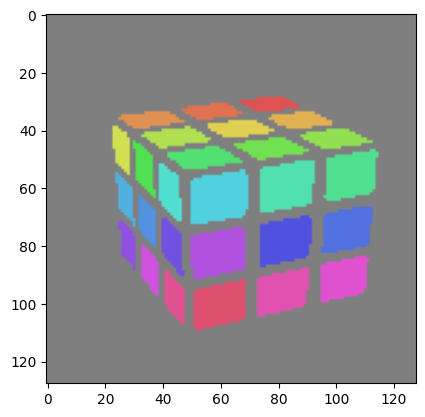

In [99]:
def post_process_masks(masks):
  masks = format_masks(masks)
  labeled_masks = label_masks(masks)
  apply_threshold(labeled_masks)
  return labeled_masks


masks = post_process_masks(masks_predicted)
idx = 2
plot_labeled_mask(masks[idx])

## Color classifier

In [54]:
class ColorClassifier(Model):
    def __init__(self, input_dir, output_file):
        input_data, file_order = load_images(input_dir, True)
        input_data = normalize(input_data)
        
        with open(output_file) as f:
            output_data = json.load(f)

        # Reorder output data to match input data.
        output_data = np.array([output_data[filename] for filename in file_order])

        self.train_dataset, self.validation_dataset, self.test_dataset = (
            self.prepare_dataset(input_data, output_data)
        )

    def build(self):
        # 32x32 image as input.
        # probability of each color as output.

        self.model = Sequential()

        # Add convolutional layers
        self.model.add(
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3))
        )
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Conv2D(64, (3, 3), activation="relu"))
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Conv2D(64, (3, 3), activation="relu"))

        # Flattening the output of the convolutional layers to feed into the dense layer
        self.model.add(layers.Flatten())

        # Add dense layers
        self.model.add(layers.Dense(64, activation="relu"))
        self.model.add(
            layers.Dense(6, activation="softmax")
        )  # 6 classes for the output layer

    def compile(self):
        self.model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )

    def train(self):
        model_history = self.model.fit(
            x=self.train_dataset["input"],
            y=self.train_dataset["output"],
            batch_size=32,
            shuffle=True,
            epochs=10,
            validation_data=(
                self.validation_dataset["input"],
                self.validation_dataset["output"],
            ),
        )

        return model_history

    def predict(self, input_data):
        predictions = self.model.predict(input_data)
        predictions = np.argmax(
            predictions, axis=1
        )  # convert one hot to class numbers.
        return predictions

In [55]:
input_data = "/home/rubiks-volume/data-ready-for-training/color-input"
output_data = "/home/rubiks-volume/data-ready-for-training/color-output.json"

colorClassifier = ColorClassifier(input_data, output_data)

colorClassifier.build()
colorClassifier.compile()

In [56]:
colorClassifier.train()

Epoch 1/10
498/498 [==============================] - 4s 7ms/step - loss: 0.0846 - accuracy: 0.9720 - val_loss: 3.1008e-04 - val_accuracy: 1.0000
Epoch 2/10
498/498 [==============================] - 3s 6ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 1.3109e-04 - val_accuracy: 1.0000
Epoch 3/10
498/498 [==============================] - 3s 6ms/step - loss: 0.0115 - accuracy: 0.9967 - val_loss: 5.2495e-04 - val_accuracy: 1.0000
Epoch 4/10
498/498 [==============================] - 3s 6ms/step - loss: 2.4599e-04 - accuracy: 1.0000 - val_loss: 3.8161e-05 - val_accuracy: 1.0000
Epoch 5/10
498/498 [==============================] - 3s 6ms/step - loss: 6.4910e-05 - accuracy: 1.0000 - val_loss: 1.5953e-05 - val_accuracy: 1.0000
Epoch 6/10
498/498 [==============================] - 3s 6ms/step - loss: 3.0006e-05 - accuracy: 1.0000 - val_loss: 7.2825e-06 - val_accuracy: 1.0000
Epoch 7/10
498/498 [==============================] - 3s 6ms/step - loss: 0.0114 - accuracy: 0.9973 - val_loss: 

In [24]:
color_predictions = colorClassifier.predict(colorClassifier.test_dataset["input"])

72/72 [==============================] - 1s 7ms/step


<Figure size 640x480 with 0 Axes>

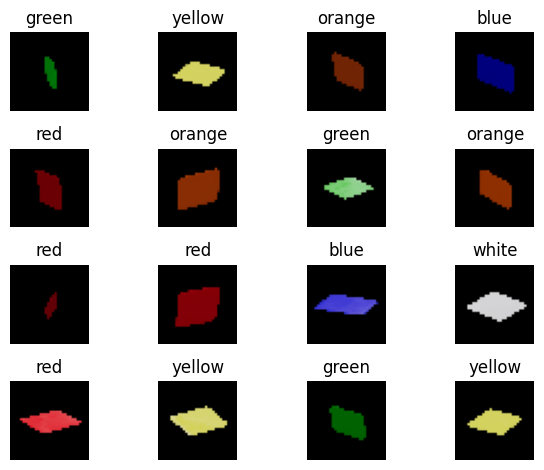

In [59]:
plot_images_grid(colorClassifier.test_dataset["input"][:16]+0.5, 4, 4, sub_titles=list(map(lambda x: color_names[x], color_predictions[:16])))

## Piece Classifier

In [60]:
class PieceClassifier(Model):
    def __init__(self, input_dir, output_file):
        input_data, file_order = load_images(input_dir, True)
        input_data = normalize(input_data)

        with open(output_file) as f:
            output_data = json.load(f)

        # Reorder output data to match input data.
        output_data = np.array([output_data[filename] for filename in file_order])

        self.train_dataset, self.validation_dataset, self.test_dataset = (
            self.prepare_dataset(input_data, output_data)
        )

    def build(self):
        self.model = Sequential()

        # Add convolutional layers
        self.model.add(
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 1))
        )
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Conv2D(64, (3, 3), activation="relu"))
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Conv2D(64, (3, 3), activation="relu"))

        # Flattening the output of the convolutional layers to feed into the dense layer
        self.model.add(layers.Flatten())

        # Add dense layers
        self.model.add(layers.Dense(64, activation="relu"))
        self.model.add(
            layers.Dense(27, activation="softmax")
        )  # 27 classes for the output layer

        # Compile the model
        self.model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )

        # Model summary
        self.model.summary()

    def compile(self):
        self.model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )

    def train(self):
        model_history = self.model.fit(
            x=self.train_dataset["input"],
            y=self.train_dataset["output"],
            batch_size=32,
            epochs=20,
            shuffle=True,
            validation_data=(
                self.validation_dataset["input"],
                self.validation_dataset["output"],
            ),
        )

        return model_history

    def predict(self, input_data):
        predictions = self.model.predict(input_data)
        predictions = np.argmax(
            predictions, axis=1
        )  # convert one hot to class numbers.
        return predictions

In [61]:
input_data = "/home/rubiks-volume/data-ready-for-training/piece-input"
output_data = "/home/rubiks-volume/data-ready-for-training/piece-output.json"

pieceClassifier = PieceClassifier(input_data, output_data)

pieceClassifier.build()
pieceClassifier.compile()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 50176)            

In [62]:
pieceClassifier.train()

Epoch 1/20
24/24 [==============================] - 2s 25ms/step - loss: 3.1811 - accuracy: 0.1177 - val_loss: 2.1693 - val_accuracy: 0.5116
Epoch 2/20
24/24 [==============================] - 0s 10ms/step - loss: 0.7857 - accuracy: 0.8122 - val_loss: 0.2632 - val_accuracy: 0.8884
Epoch 3/20
24/24 [==============================] - 0s 9ms/step - loss: 0.1884 - accuracy: 0.9206 - val_loss: 0.1854 - val_accuracy: 0.9442
Epoch 4/20
24/24 [==============================] - 0s 9ms/step - loss: 0.0881 - accuracy: 0.9669 - val_loss: 0.0768 - val_accuracy: 0.9721
Epoch 5/20
24/24 [==============================] - 0s 9ms/step - loss: 0.0601 - accuracy: 0.9828 - val_loss: 0.0533 - val_accuracy: 0.9814
Epoch 6/20
24/24 [==============================] - 0s 10ms/step - loss: 0.0272 - accuracy: 0.9894 - val_loss: 0.0429 - val_accuracy: 0.9814
Epoch 7/20
24/24 [==============================] - 0s 9ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0160 - val_accuracy: 0.9953
Epoch 8/20
24/24 

In [63]:
piece_predictions = pieceClassifier.predict(pieceClassifier.test_dataset["input"])

4/4 [==============================] - 0s 7ms/step


<Figure size 640x480 with 0 Axes>

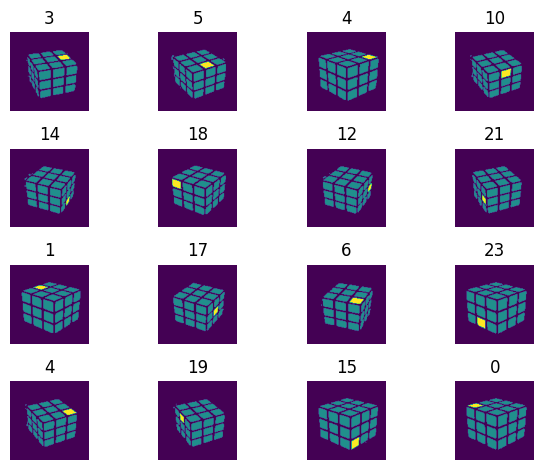

In [64]:
plot_images_grid(pieceClassifier.test_dataset["input"][:16]+0.5, 4, 4, sub_titles=piece_predictions[:16])

# Models integration

In [131]:
def create_masks(unet_model, input_data):
  # TODO: apply thereshold to the masks?
  masks_predicted = unet_model.predict(input_data)
  formated_masks = format_masks(masks_predicted)
  return formated_masks

def create_labeled_masks(unet_model, input_data):
  formated_masks = create_masks(unet_model, input_data)

  # Split masks into subareas.
  labeled_masks = np.squeeze(label_masks(formated_masks))

  apply_threshold(labeled_masks)

  return labeled_masks

def create_centers_set(labeled_masks):
  centers_set = []
  for mask in labeled_masks:
    unique, indices = np.unique(mask, return_index=True)

    # Get the indices where each unique value occurs in 'mask'. Then calculate
    # the mean of the indices for each unique value
    true_indices = [np.where(mask == value) for value in unique[1:]]
    means = np.array([[np.mean(indices[0]), np.mean(indices[1])] for indices in true_indices])
    centers = np.around(means).astype(np.uint8)
    centers_set.append(centers)

  return centers_set

# Temporary solution! Removes all datapoints that doesn't have 27 centers.
def remove_bad_datapoints(centers_set, other_sets):
  print(f"Number of datapoints before removal: {len(centers_set)}")

  bad_indicies = []
  for i, datapoint in enumerate(centers_set):
    if len(datapoint) != 27:
      bad_indicies.append(i)

  # Remove bad datapoints.
  centers_set = np.array([datapoint for i, datapoint in enumerate(centers_set) if i not in bad_indicies])
  filtered_datasets = []
  for dataset in other_sets:
    filtered_datasets.append(np.array([datapoint for i, datapoint in enumerate(dataset) if i not in bad_indicies]))
  
  print(f"Number of datapoints after removal: {len(centers_set)}")

  return centers_set, filtered_datasets

def crop_color_area(rubiks_image, labeled_mask, center):
  size = 32
  img = rubiks_image+0.5
  img[labeled_mask != labeled_mask[center[0], center[1]]] = [0, 0, 0]
  cropped = img[center[0] - size//2:center[0] + size//2, center[1] - size//2:center[1] + size//2]
  return cropped
      
def crop_color_areas(rubiks_images, labeled_masks, centers_set):
  size = 32

  cropped_images_set = []
  for idx in range(len(rubiks_images)):
    mask = labeled_masks[idx]
    classes = np.unique(mask)[1:] # ignore background

    cropped_images = []
    for area_index in range(27):
      img = rubiks_images[idx]+0.5
      img[mask != classes[area_index]] = [0, 0, 0]
      center_y, center_x = centers_set[idx][area_index]
      cropped = img[center_y - size//2:center_y + size//2, center_x - size//2:center_x + size//2]
      cropped_images.append(cropped)

    cropped_images_set.append(cropped_images)

  return np.array(cropped_images_set)
      



4/4 [==============================] - 0s 114ms/step
Number of datapoints before removal: 101
Number of datapoints after removal: 87
1/1 [==============================] - 0s 15ms/step


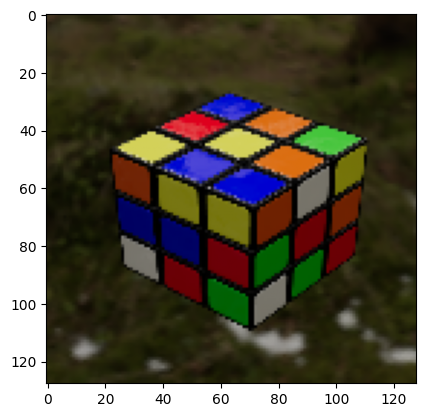

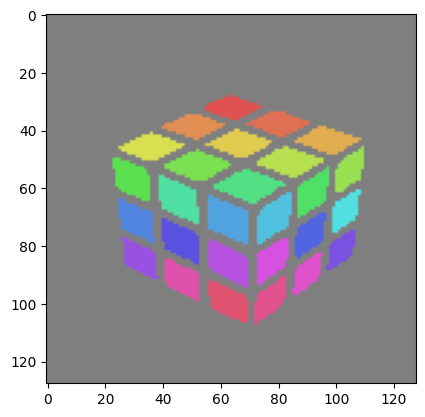

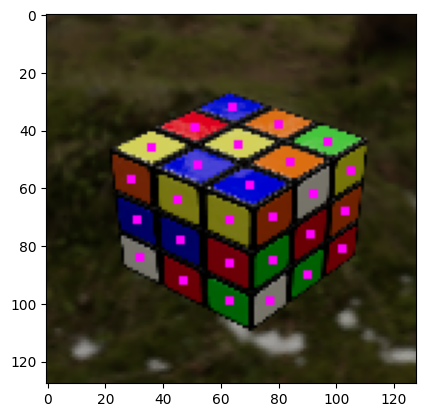

<Figure size 640x480 with 0 Axes>

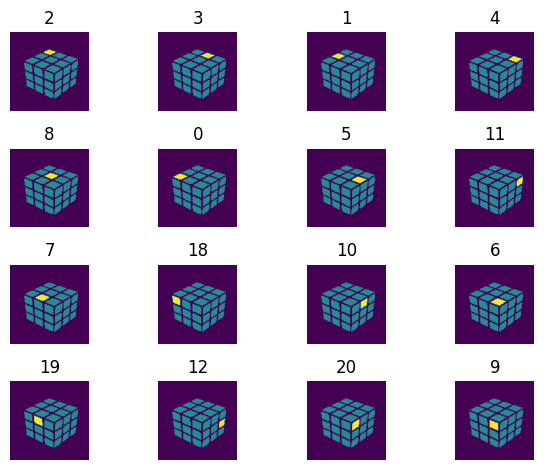

<Figure size 640x480 with 0 Axes>

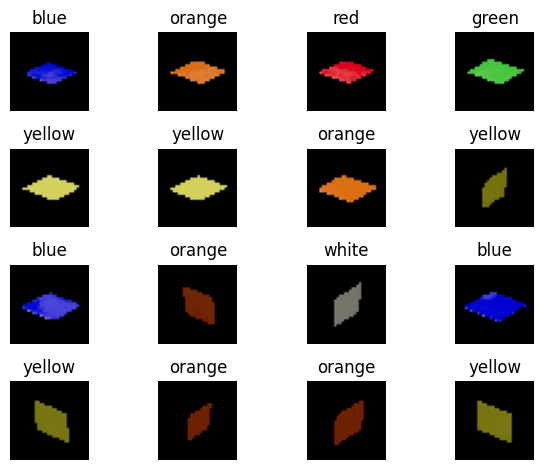

<Figure size 640x480 with 0 Axes>

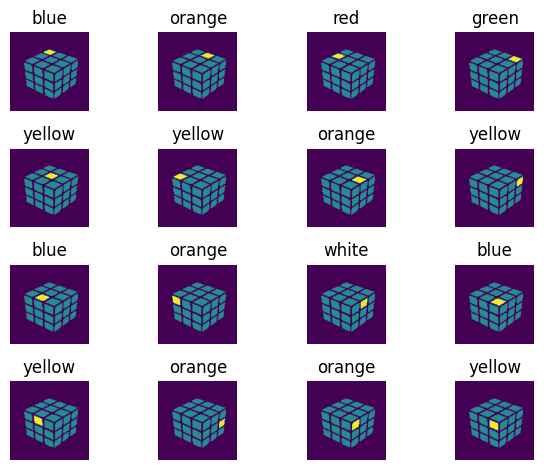

In [135]:
idx = 0

rubiks_imgs = segmentationModel.test_dataset["input"]
labeled_masks = create_labeled_masks(segmentationModel.model, rubiks_imgs)
centers_set = create_centers_set(labeled_masks)
centers_set, [rubiks_imgs, labeled_masks] = remove_bad_datapoints(
    centers_set, [rubiks_imgs, labeled_masks]
)

# Create seperate images for each label in each mask.
labeled_mask = labeled_masks[idx]
unique_labels = np.unique(labeled_mask)
unique_labels = unique_labels[1:] # Ignore background label.

piece_images = []
cropped_images = []
for i, l in enumerate(unique_labels):
  img = np.zeros((128, 128))
  img[np.where(labeled_mask)] = 0.5
  img[np.where(labeled_mask == l)] = 1
  piece_images.append(img)

  cropped = crop_color_area(rubiks_imgs[idx], labeled_mask, centers_set[idx][i])
  cropped_images.append(cropped)
  
piece_images = np.array(piece_images)
cropped_images = np.array(cropped_images)
piece_predictions = pieceClassifier.predict(piece_images-0.5)
color_predictions = colorClassifier.predict(cropped_images-0.5)


plot_images([rubiks_imgs[idx]+0.5])
plot_labeled_mask(labeled_masks[idx])
draw_centers(rubiks_imgs[idx], centers_set[idx])
plot_images_grid(piece_images[:16], 4, 4, sub_titles=piece_predictions[:16])
plot_images_grid(cropped_images[:16], 4, 4, sub_titles=list(map(lambda x: color_names[x], color_predictions[:16])))
#plot_images_grid(piece_images[:16], 4, 4, sub_titles=list(map(lambda x: color_names[x], color_predictions[:16])))

# Rubiks Visualizer

In [ ]:
# Kod finns i local-to-global.py

Local to global:

<img src="https://drive.usercontent.google.com/download?id=1Z6XAi9FrZ9QNGAIlMgb3KPSP3VN-Dud1&export=view&authuser=0" width="300 px"/>

In [ ]:
viz = np.zeros((3*4, 3*3, 3))

# Draw fixed pieces.
fixed_offset = 50
viz[1][4] = [0, 0, 255-fixed_offset]
viz[4][1] = [255-fixed_offset, 0, 0]
viz[4][4] = [255-fixed_offset, 255-fixed_offset, 0]
viz[4][7] = [255-fixed_offset, 165-fixed_offset, 0]
viz[7][4] = [0, 255-fixed_offset, 0]
viz[10][4] = [255-fixed_offset, 255-fixed_offset, 255-fixed_offset]

colors = {
  "yellow": [255, 255, 0],
  "green": [0, 255, 00],
  "blue": [0, 0, 255],
  "red": [255, 0, 0],
  "orange": [255, 165, 0],
  "white": [255, 255, 255]
}

# Create (m)ap between piece and visualization.
m = {
    ("U", 0): (3, 3),
    ("U", 1): (3, 4),
    ("U", 2): (3, 5),
    ("U", 3): (4, 5),
    ("U", 4): (5, 5),
    ("U", 5): (5, 4),
    ("U", 6): (5, 3),
    ("U", 7): (4, 3),

}

# Offset each side in relaton to side U.
for i in range(8):
  m[("B", i)] = m[("U", i)][0]-3, m[("U", i)][1]
  m[("L", i)] = m[("U", i)][0], m[("U", i)][1]-3
  m[("R", i)] = m[("U", i)][0], m[("U", i)][1]+3
  m[("F", i)] = m[("U", i)][0]+3, m[("U", i)][1]
  m[("D", i)] = m[("U", i)][0]+6, m[("U", i)][1]

# Assign default colors for test.
for i in range(8):
  viz[m[("U", i)]] = colors["yellow"]
  viz[m[("F", i)]] = colors["green"]
  viz[m[("B", i)]] = colors["blue"]
  viz[m[("L", i)]] = colors["red"]
  viz[m[("R", i)]] = colors["orange"]
  viz[m[("D", i)]] = colors["white"]

# Try to change this as a test.
#viz[m[("F", 0)]] = [255, 0, 255]

plot_images([viz.astype(np.uint8)])

In [ ]:
# Define offsets between camera indeces and global indices for different cube orientations.
# For instance, if the cube is oriented with the yellow side up and blue side front
# the offset for all indices on side (U)pp will be: offsets_U[("yellow", "blue")].
offsets_U={("green","yellow"):4,("green","white"):0,("green","red"):2,("green","orange"):6,("yellow","green"):0,("yellow","blue"):4,("yellow","red"):2,("yellow","orange"):6,("blue","yellow"):0,("blue","white"):4,("blue","red"):2,("blue","orange"):6,("white","green"):4,("white","blue"):0,("white","red"):2,("white","orange"):6,("red","green"):0,("red","yellow"):6,("red","blue"):4,("red","white"):2,("orange","green"):0,("orange","yellow"):2,("orange","blue"):4,("orange","white"):6}
offsets_F={("yellow","green"):0,("white","green"):4,("red","green"):6,("orange","green"):2,("green","yellow"):4,("blue","yellow"):0,("red","yellow"):6,("orange","yellow"):2,("yellow","blue"):4,("white","blue"):0,("red","blue"):6,("orange","blue"):2,("green","white"):0,("blue","white"):4,("red","white"):6,("orange","white"):2,("green","red"):4,("yellow","red"):2,("blue","red"):0,("white","red"):6,("green","orange"):4,("yellow","orange"):6,("blue","orange"):0,("white","orange"):2}
offsets_L={("yellow","orange"):0,("orange","white"):2,("white","red"):4,("red","yellow"):6,("blue","orange"):0,("orange","green"):2,("green","red"):4,("red","blue"):6,("white","orange"):0,("orange","yellow"):2,("yellow","red"):4,("red","white"):6,("green","orange"):0,("orange","blue"):2,("blue","red"):4,("red","green"):6,("blue","yellow"):0,("yellow","green"):2,("green","white"):4,("white","blue"):6,("blue","white"):0,("white","green"):2,("green","yellow"):4,("yellow","blue"):6}

In [ ]:
# Test with random photo.

# Reset visualiation.
for side in ["U", "F", "B", "L", "R", "D"]:
  for i in range(8):
    viz[m[(side, i)]] = [50, 50, 50]

def local_to_global(local):
  return (local + offset) % 8

# Below we are manually entering the values as they are seen by the camera.

# The side that is (U)pp for the camera.
# The following three blocks represents the first image.
offset = offsets_U[("green", "orange")]
viz[m[("F", local_to_global(0))]] = colors["orange"]
viz[m[("F", local_to_global(1))]] = colors["red"]
viz[m[("F", local_to_global(2))]] = colors["green"]
viz[m[("F", local_to_global(3))]] = colors["orange"]
viz[m[("F", local_to_global(4))]] = colors["yellow"]
viz[m[("F", local_to_global(5))]] = colors["green"]
viz[m[("F", local_to_global(6))]] = colors["white"]
viz[m[("F", local_to_global(7))]] = colors["orange"]

offset = offsets_L[("green", "orange")]
viz[m[("D", local_to_global(0))]] = colors["yellow"]
viz[m[("D", local_to_global(1))]] = colors["yellow"]
viz[m[("D", local_to_global(2))]] = colors["blue"]
viz[m[("D", local_to_global(3))]] = colors["yellow"]
viz[m[("D", local_to_global(4))]] = colors["green"]
viz[m[("D", local_to_global(5))]] = colors["white"]
viz[m[("D", local_to_global(6))]] = colors["yellow"]
viz[m[("D", local_to_global(7))]] = colors["orange"]

offset = offsets_F[("green", "orange")]
viz[m[("R", local_to_global(0))]] = colors["orange"]
viz[m[("R", local_to_global(1))]] = colors["red"]
viz[m[("R", local_to_global(2))]] = colors["blue"]
viz[m[("R", local_to_global(3))]] = colors["blue"]
viz[m[("R", local_to_global(4))]] = colors["white"]
viz[m[("R", local_to_global(5))]] = colors["yellow"]
viz[m[("R", local_to_global(6))]] = colors["yellow"]
viz[m[("R", local_to_global(7))]] = colors["blue"]

# The following three blocks represents the second image.
offset = offsets_U[("blue", "yellow")]
viz[m[("B", local_to_global(0))]] = colors["green"]
viz[m[("B", local_to_global(1))]] = colors["blue"]
viz[m[("B", local_to_global(2))]] = colors["yellow"]
viz[m[("B", local_to_global(3))]] = colors["green"]
viz[m[("B", local_to_global(4))]] = colors["green"]
viz[m[("B", local_to_global(5))]] = colors["white"]
viz[m[("B", local_to_global(6))]] = colors["red"]
viz[m[("B", local_to_global(7))]] = colors["yellow"]

offset = offsets_L[("blue", "yellow")]
viz[m[("L", local_to_global(0))]] = colors["red"]
viz[m[("L", local_to_global(1))]] = colors["white"]
viz[m[("L", local_to_global(2))]] = colors["blue"]
viz[m[("L", local_to_global(3))]] = colors["red"]
viz[m[("L", local_to_global(4))]] = colors["orange"]
viz[m[("L", local_to_global(5))]] = colors["white"]
viz[m[("L", local_to_global(6))]] = colors["blue"]
viz[m[("L", local_to_global(7))]] = colors["blue"]

offset = offsets_F[("blue", "yellow")]
viz[m[("U", local_to_global(0))]] = colors["white"]
viz[m[("U", local_to_global(1))]] = colors["green"]
viz[m[("U", local_to_global(2))]] = colors["red"]
viz[m[("U", local_to_global(3))]] = colors["red"]
viz[m[("U", local_to_global(4))]] = colors["red"]
viz[m[("U", local_to_global(5))]] = colors["green"]
viz[m[("U", local_to_global(6))]] = colors["white"]
viz[m[("U", local_to_global(7))]] = colors["yellow"]

plot_images([viz.astype(np.uint8)])

Bild 1:
<img src="https://drive.usercontent.google.com/download?id=10M2SPbnMXVYerxURmAyjQf3NFGkw51RN&export=view&authuser=0" width="300 px"/>

Bild 2:
<img src="https://drive.usercontent.google.com/download?id=10dlI0rI4dReJc4DeX2HeWxy5y3qEhoJn&export=view&authuser=0" width="300 px"/>

# Processing Data From Rubiks Generator
The code in this section does processing on the images that have been created in the Three.js Rubiks cube simulator to prepare them as dataset for the machine learning models above. Once the dataset is generated the code in this section doesn't need to be run anymore.

Since a segmentation model is needed in this section, one is loaded from a previous run from disk. However, it is the exact same model that is trained above.

To make it as realistic as possible I don't want to save entire arrays using pickle or similar, but rather everything should be stored as images or JSON. Therefore some small preprocessing will still be necesarry (normalizing, removing color channels, etc).

In [41]:
segmentationModel = keras.models.load_model('/home/rubiks-volume/models/segmentation_model')

In [86]:
# color_output contains the correct color for each area.
def crop_color_input_images(color_input, color_ouput, labeled_masks, centers_set):
  size = 32

  cropped_images = []
  color_labels = []
  for idx in range(color_input.shape[0]):
    mask = labeled_masks[idx]
    classes = np.unique(mask)[1:] # ignore background
    output_image = color_ouput[idx]

    for area_index in range(27):
      img = color_input[idx]+0.5
      img[mask != classes[area_index]] = [0, 0, 0]
      center_y, center_x = centers_set[idx][area_index]
      cropped = img[center_y - size//2:center_y + size//2, center_x - size//2:center_x + size//2]
      cropped_images.append(cropped)

      color = output_image[center_y][center_x]
      color_labels.append(color_classes[tuple(color)])


  return np.array(cropped_images), np.array(color_labels)

In [ ]:
# Preprocess data for segmentation model and store to disk.

# No preprocessing required for the segmentation model.

In [ ]:
# Preprocess data for color classification model and store to disk.
def load_raw_data():
    normal_color_labels_dir = "/home/rubiks-volume/preprocessed/normal-color-labels"
    color_labels_dir = "/home/rubiks-volume/preprocessed/color-labels"
    normal_color_labels, color_labels = load_in_and_out_images(
        normal_color_labels_dir, color_labels_dir
    )
    normal_color_labels = normalize(normal_color_labels)

    return normal_color_labels, color_labels


input_data, output_data = load_raw_data()
labeled_masks = create_labeled_masks(segmentationModel, input_data)
centers_set = create_centers_set(labeled_masks)
centers_set, [input_data, output_data, labeled_masks] = remove_bad_datapoints(
    centers_set, [input_data, output_data, labeled_masks]
)

color_input, color_output = crop_color_input_images(input_data, output_data, labeled_masks, centers_set)
#plot_images_grid(color_input[16:32], 4, 4, list(map(lambda x: color_names[x], color_output[16:32])))

# Save the preprocessed data to disk.
input_dir = "/home/rubiks-volume/data-ready-for-training/color-input"

color_output_map = {}
for idx, img in enumerate(color_input):
  filename = f"{uuid.uuid4()}.png"
  color_output_map[filename] = int(color_output[idx])

  img = Image.fromarray((img * 255).astype(np.uint8))
  img.save(os.path.join(input_dir, filename))

with open("/home/rubiks-volume/data-ready-for-training/color-output.json", "w") as f:
    json.dump(color_output_map, f)

32/32 [==============================] - 1s 39ms/step
Number of datapoints before removal: 1000
Number of datapoints after removal: 843


34/34 [==============================] - 1s 41ms/step


<Figure size 640x480 with 0 Axes>

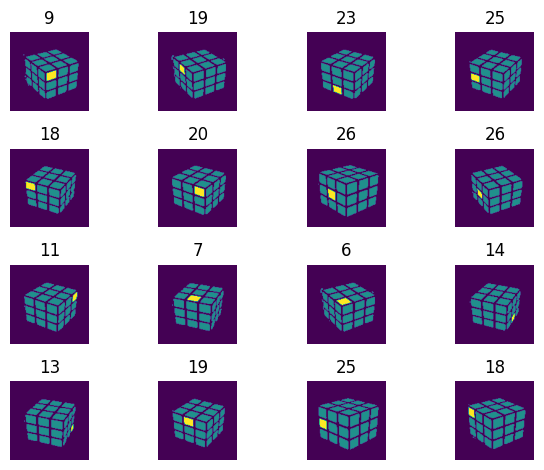

In [40]:
# Preprocess data for piece classification model and store to disk.
def generate_piece_bw_input(formated_masks, piece_highlighted):
  bw = np.zeros(formated_masks.shape)
  bw[np.where(formated_masks)] = 0.5

  mask = np.all(piece_highlighted == np.array([255, 0, 255]), axis=-1)
  bw[np.where(mask)[:3]] = 1

  return bw

def load_raw_data():
  piece_input_dir = '/home/rubiks-volume/preprocessed/piece-input'
  piece_output_dir = '/home/rubiks-volume/preprocessed/piece-output'

  piece_input, piece_output, file_order = load_in_and_out_images(piece_input_dir, piece_output_dir, True)
  piece_input = normalize(piece_input)

  with open("/home/rubiks-volume/piece-classifications.json") as f:
    piece_class_map = json.load(f)

  piece_classes = np.array(list(map(lambda x: piece_class_map[x], file_order)))

  return piece_input, piece_output, piece_classes

piece_normal, piece_highlighted, piece_classes = load_raw_data()
formated_masks = create_masks(segmentationModel, piece_normal)
bw = generate_piece_bw_input(formated_masks, piece_highlighted)
plot_images_grid(bw[:16], 4, 4, piece_classes[:16])

# Save the preprocessed data to disk.
input_dir = "/home/rubiks-volume/data-ready-for-training/piece-input"

piece_classes_map = {}
for idx, img in enumerate(bw):
  filename = f"{uuid.uuid4()}.png"
  piece_classes_map[filename] = int(piece_classes[idx])

  img = Image.fromarray((img * 255).astype(np.uint8))
  img.save(os.path.join(input_dir, filename))

with open("/home/rubiks-volume/data-ready-for-training/piece-output.json", "w") as f:
    json.dump(piece_classes_map, f)

# Legacy

## Fixed Piece Classifier

In [ ]:
def load_raw_data():
  input_fixed_dir = '/home/rubiks-volume/preprocessed/input-fixed'
  labels_fixed_dir = '/home/rubiks-volume/preprocessed/labels-fixed'
  input_fixed, labels_fixed = load_in_and_out_images(input_fixed_dir, labels_fixed_dir)
  input_fixed = normalize(input_fixed)

  return input_fixed, labels_fixed

32/32 [==============================] - 2s 69ms/step


<ipython-input-25-97f1f979229f>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masks = ~masks.astype(np.bool)


Number of datapoints before removal: 1000
Number of datapoints after removal: 883


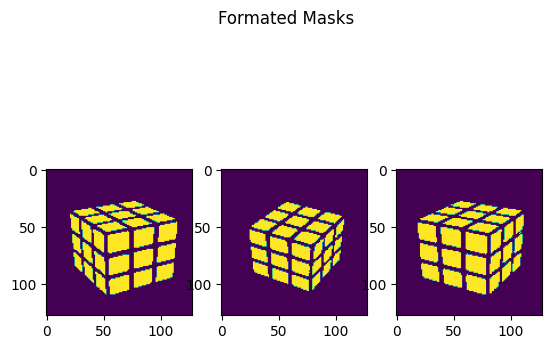

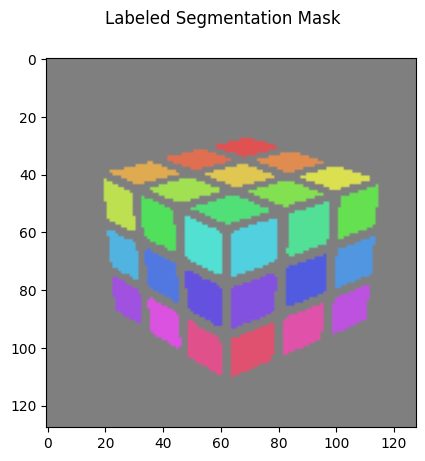

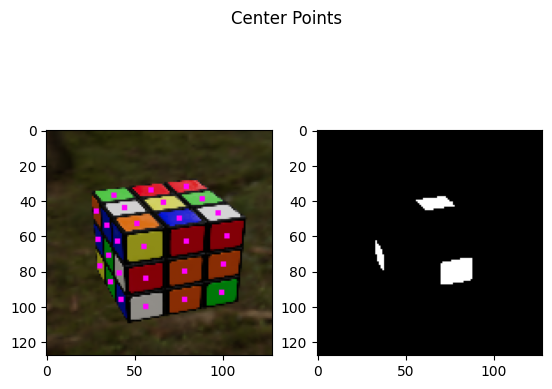

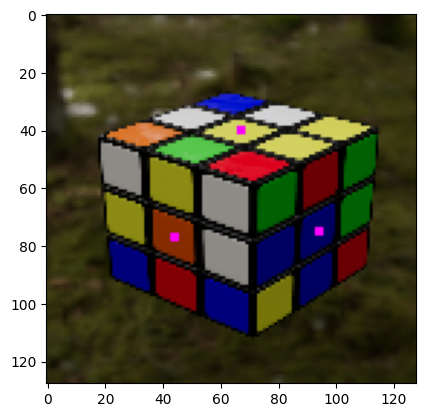

In [ ]:
def create_labeled_masks(input_fixed):
  # Create masks.
  masks_predicted = unet_model.predict(input_fixed)
  formated_masks = format_masks(masks_predicted)
  plot_images(formated_masks[:3], title="Formated Masks")

  # Split masks into subareas.
  labeled_masks = [label(mask, connectivity=2) for mask in formated_masks]
  labeled_masks = np.array(labeled_masks)

  # Set all classes with count less than threshold to 0 (background).
  threshold = 16
  for idx in range(labeled_masks.shape[0]):
    mask = labeled_masks[idx]
    label_classes, counts = np.unique(mask, return_counts=True)
    invalid_classes = label_classes[counts < threshold]
    invalid_mask = np.isin(mask, invalid_classes)
    mask[invalid_mask] = 0

  # Visualize each subarea of the segmentation mask with a unique color.
  idx = 20
  unique_colors = generate_unique_colors(np.max(labeled_masks[idx]))
  unique_colors = [[0.5, 0.5, 0.5]] + unique_colors # add background color.
  unique_colors = np.array(unique_colors)
  img = unique_colors[labeled_masks[idx]]
  plot_images([img], "Labeled Segmentation Mask")

  return labeled_masks

def create_centers_set(input_fixed, labels_fixed, labeled_masks):
  centers_set = []
  for mask in labeled_masks:
    unique, indices = np.unique(mask, return_index=True)

    # Get the indices where each unique value occurs in 'mask'. Then calculate
    # the mean of the indices for each unique value
    true_indices = [np.where(mask == value) for value in unique[1:]]
    means = np.array([[np.mean(indices[0]), np.mean(indices[1])] for indices in true_indices])
    centers = np.around(means).astype(np.uint8)
    centers_set.append(centers)

  # Visualize center points.
  idx = 5
  image_in = input_fixed[idx] + 0.5
  for c in centers_set[idx]:
    draw_point(image_in, c[0], c[1])

  plot_images([image_in, labels_fixed[idx]], "Center Points")

  return centers_set

# Temporary solution! Removes all datapoints that doesn't have 27 centers.
def remove_bad_datapoints(input_fixed, labels_fixed, labeled_masks, centers_set):
  print(f"Number of datapoints before removal: {input_fixed.shape[0]}")

  bad_indicies = []
  for i, datapoint in enumerate(centers_set):
    if len(datapoint) != 27:
      bad_indicies.append(i)

  # Remove bad datapoints.
  input_fixed = np.array([datapoint for i, datapoint in enumerate(input_fixed) if i not in bad_indicies])
  labels_fixed = np.array([datapoint for i, datapoint in enumerate(labels_fixed) if i not in bad_indicies])
  labeled_masks = np.array([datapoint for i, datapoint in enumerate(labeled_masks) if i not in bad_indicies])
  centers_set = np.array([datapoint for i, datapoint in enumerate(centers_set) if i not in bad_indicies])

  print(f"Number of datapoints after removal: {input_fixed.shape[0]}")

  return input_fixed, labels_fixed, labeled_masks, centers_set

def create_is_fixed_set(labels_fixed, centers_set, input_fixed):

  # Preprocessing of labels.

  # For each input datapoint generate an array of 0/1 indicating if piece is
  # fixed or not.
  is_fixed_set = []
  for i in range(labels_fixed.shape[0]):
    is_fixed = []
    for (row, col) in centers_set[i]:
      is_fixed.append(1.0 if labels_fixed[i][row][col][0] == 255 else 0.0)
    is_fixed_set.append(is_fixed)
  is_fixed_set = np.array(is_fixed_set)

  # Test the new datapoints.
  random_idx = 512

  img_cpy = input_fixed[random_idx]+0.5

  for i, center in enumerate(centers_set[random_idx]):
    if is_fixed_set[random_idx][i]:
      draw_point(img_cpy, center[0], center[1])

  plot_images([img_cpy])

  return is_fixed_set

def preprocess_fixed_piece():
  input_fixed, labels_fixed = load_raw_data()
  labeled_masks = create_labeled_masks(input_fixed)
  centers_set = create_centers_set(input_fixed, labels_fixed, labeled_masks)
  input_fixed, labels_fixed, labeled_masks, centers_set = remove_bad_datapoints(
    input_fixed, labels_fixed, labeled_masks, centers_set)
  is_fixed_set = create_is_fixed_set(labels_fixed, centers_set, input_fixed)

  return input_fixed, centers_set, is_fixed_set

input_fixed, centers_set, is_fixed_set = preprocess_fixed_piece()

In [ ]:
DataSplitRatios=(0.7,0.2,0.1)
n = len(centers_set)
split1ix = int(n*DataSplitRatios[0])
split2ix = int(n*(DataSplitRatios[0]+DataSplitRatios[1]))

fixed_input_train = centers_set[:split1ix]
fixed_output_train = is_fixed_set[:split1ix]

fixed_input_valid = centers_set[split1ix:split2ix]
fixed_output_valid = is_fixed_set[split1ix:split2ix]

fixed_input_test = centers_set[split2ix:]
fixed_output_test = is_fixed_set[split2ix:]

# The network expects coordinates to be flattened.
fixed_input_train = np.array([arr.flatten() for arr in fixed_input_train])
fixed_input_valid = np.array([arr.flatten() for arr in fixed_input_valid])
fixed_input_test = np.array([arr.flatten() for arr in fixed_input_test])

print(len(fixed_input_train))
print(len(fixed_output_train))
print(len(fixed_input_valid))
print(len(fixed_output_valid))
print(len(fixed_input_test))
print(len(fixed_output_test))

618
618
176
176
89
89


In [ ]:
# Fixed piece classifier.
# Input: 27 coordinates, representing the center of each segmented area.
# Output: 27 values representing each area. A value close to 1 indicates that it
# the area is a fixed piece.

# Define the model
fixedClassifier = Sequential([
    # Input layer: Assuming flat input of 54 units (27 vectors of size 2)
    InputLayer(input_shape=(54,)),

    # Dense layers

    # Completely arbitrary, but seems to work well.

    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),


    # Output layer: 27 units for 27 outputs, with sigmoid activation for outputs between 0 and 1
    Dense(27, activation='sigmoid')
])


def boolean_accuracy(y_true, y_pred, threshold=0.5):
    """
    Custom accuracy metric that treats model outputs as boolean values.
    Predictions greater than `threshold` are considered True/1, otherwise False/0.
    Parameters:
    - y_true: Tensor of true labels.
    - y_pred: Tensor of predicted labels.
    - threshold: Float representing the threshold to consider predictions as True/1.
    """
    # Convert predictions to boolean values based on threshold
    y_pred_boolean = tf.cast(y_pred > threshold, tf.float32)

    # Calculate accuracy as the mean of correct predictions
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_boolean), tf.float32))
    return accuracy

# Compile the model
fixedClassifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=[boolean_accuracy])

# Summary of the model
fixedClassifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7040      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 27)                3

In [ ]:
NUM_EPOCHS = 30


model_history = fixedClassifier.fit(x=fixed_input_train,
                               y=fixed_output_train,
                               batch_size=32,
                               epochs=NUM_EPOCHS,
                               shuffle=True,
                               validation_data=(fixed_input_valid, fixed_output_valid))

Epoch 1/30
20/20 [==============================] - 2s 16ms/step - loss: 0.5836 - boolean_accuracy: 0.8713 - val_loss: 0.1095 - val_boolean_accuracy: 0.9441
Epoch 2/30
20/20 [==============================] - 0s 9ms/step - loss: 0.0799 - boolean_accuracy: 0.9677 - val_loss: 0.0745 - val_boolean_accuracy: 0.9711
Epoch 3/30
20/20 [==============================] - 0s 10ms/step - loss: 0.0508 - boolean_accuracy: 0.9815 - val_loss: 0.0336 - val_boolean_accuracy: 0.9904
Epoch 4/30
20/20 [==============================] - 0s 10ms/step - loss: 0.0298 - boolean_accuracy: 0.9912 - val_loss: 0.0197 - val_boolean_accuracy: 0.9959
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 0.0149 - boolean_accuracy: 0.9953 - val_loss: 0.0165 - val_boolean_accuracy: 0.9961
Epoch 6/30
20/20 [==============================] - 0s 9ms/step - loss: 0.0108 - boolean_accuracy: 0.9964 - val_loss: 0.0139 - val_boolean_accuracy: 0.9965
Epoch 7/30
20/20 [==============================] - 0s 9ms/st

In [ ]:
fixed_predicted = fixedClassifier.predict(fixed_input_test)

3/3 [==============================] - 0s 3ms/step


In [ ]:
fixed_predicted[0].shape

(27,)

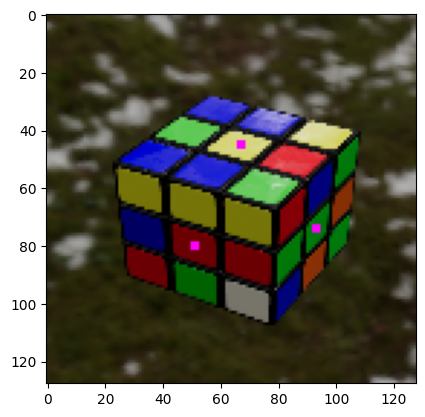

In [ ]:
# Test predictions from fixed piece classifier.
centers = centers_set[split2ix:]
test_images = input_fixed[split2ix:]

idx = 10

img_cpy = test_images[idx]+0.5
bit_centers = centers[idx]

for i, center in enumerate(bit_centers):
  if(fixed_predicted[idx][i] > 0.5):
    draw_point(img_cpy, center[0], center[1])

plot_images([img_cpy])

In [ ]:
# Find predictions with number of true classes other than 3.
for i, datapoint in enumerate(fixed_predicted):
  true_classes = datapoint[datapoint>0.5]
  if true_classes.shape[0] != 3:
    print(f"Bad index: {i}")

In [ ]:
def format_masks(masks):
    masks_one_channel = (masks[:,:,:,:1]*255).astype(np.uint8)
    masks_one_channel[masks_one_channel >= 128] = 255
    masks_one_channel[masks_one_channel < 128] = 0
    return ~masks_one_channel

In [ ]:
plot_images(format_masks(masks)[:4], "gray")

In [ ]:
import numpy as np

def find_areas(mask):
    rows, cols = mask.shape[:2]
    visited = np.zeros_like(mask, dtype=bool)
    areas = []

    # Define the 8 possible directions (vertical, horizontal, and diagonal)
    directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

    def is_valid(row, col):
        return 0 <= row < rows and 0 <= col < cols

    def dfs(row, col, area):
        if visited[row, col] or mask[row, col] == 0:
            return
        visited[row, col] = True
        area.append((row, col))
        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            if is_valid(new_row, new_col) and mask[new_row, new_col] == mask[row, col]:
                dfs(new_row, new_col, area)

    for row in range(rows):
        for col in range(cols):
            if mask[row, col] != 0 and not visited[row, col]:
                current_area = []
                dfs(row, col, current_area)
                areas.append(current_area)

    # Convert each area's list of coordinates to an array of pixel values
    #area_values = [np.array([mask[row, col] for row, col in area]) for area in areas]
    #return area_values
    return areas

# Example usage
areas = find_areas(format_masks(masks)[0])  # Assuming the mask is in the last dimension
print(f"Found {len(areas)} areas.")